In [1]:
import numpy as np
import networkx as nx
from networkx import grid_graph
from scipy import linalg
from scipy.special import sici
import math
from matplotlib import pyplot as plt

# Poulson Algorithm 1

In [2]:
def sampling_algorithm_1(K):
    
    n = len(K)
    
    sample = []
    A = K.copy()

    for j in range(n):

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

    return sample, A


# Poulson Algorithm 3/4

In [3]:
def sampling_algorithm_3(K):
    
    block_size = 32
    n = len(K)

    sample = []
    A = K.copy()
    
    for j in range(n):
        
        bsize = min(block_size, n-j)
        
        J_1 = slice(j, bsize + j)
        J_2 = slice(j + bsize, n)
                
        sub_sample, A[J_1,J_1] = sampling_algorithm_1(A[J_1,J_1])
        
        for s in sub_sample:
            sample.append(s + j)
            
        _, tril, triu  = linalg.lu(A[J_1,J_1])
        
        A[J_2,J_1] = np.dot(
            A[J_2,J_1],
            linalg.inv(triu),
        )
        
        A[J_1,J_2] = np.dot(
            linalg.inv(tril), 
            A[J_1,J_2],
        )
         
        A[J_2,J_2] -= np.dot(A[J_2,J_1], A[J_1,J_2])
        
        j += bsize
        
    return sample, A

# Uniform Spanning Trees

C:\Users\samki\AppData\Local\Temp\ipykernel_18320\2504094098.py:9: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(G).todense()


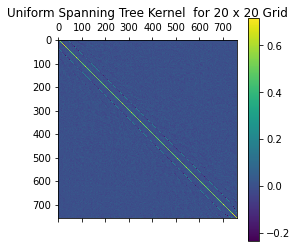

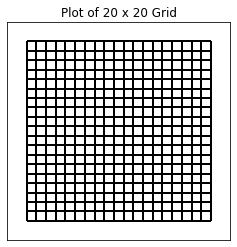

In [4]:
grid_dims = 20

# Create a grid with dimension grid_dims x grid_dims
G = grid_graph(dim=(grid_dims, grid_dims))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
weights = [2 for u,v in G.edges()]

# The vertex-edge incidence matrix
A = nx.incidence_matrix(G).todense()
A_T = A.transpose()
AA_T = A.dot(A_T)

# Compute the kernel K from the vertex-edge incidence matrix 
K = A_T.dot(linalg.inv(AA_T)).dot(A)

plt.matshow(np.array(K))
plt.colorbar()
plt.title("Uniform Spanning Tree Kernel  for %d x %d Grid" % (grid_dims, grid_dims))

plt.figure(3,figsize=(4,4)) 
plt.title("Plot of %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
)
plt.show()

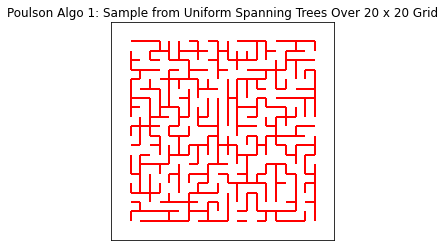

In [5]:
# Sample from the point process

samples,_ = sampling_algorithm_1(K)

plt.figure(3,figsize=(4,4)) 
plt.title("Poulson Algo 1: Sample from Uniform Spanning Trees Over %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
    edgelist = [edge for i,edge in enumerate(G.edges()) if i in samples],
    edge_color='red'
)
plt.show()

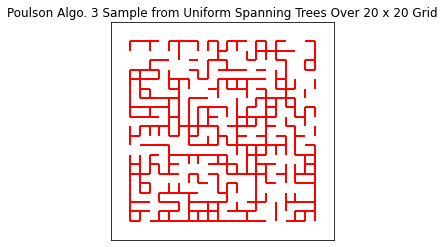

In [6]:
# Sample from the point process

samples,_ = sampling_algorithm_3(K)

plt.figure(3,figsize=(4,4)) 
plt.title("Poulson Algo. 3 Sample from Uniform Spanning Trees Over %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
    edgelist = [edge for i,edge in enumerate(G.edges()) if i in samples],
    edge_color='red'
)
plt.show()

# Discretized Sine Process

[7.170e-01 1.451e-01 5.400e-03 1.000e-04 0.000e+00 0.000e+00 0.000e+00]


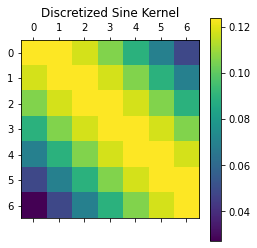

[2]


In [216]:
k=3

def compute_sine_kernel_entry(m,l):
    try: 
        upper = sici(1/(2**k)*math.pi*(m-l-1))[0]
    except:
        upper = sici(1/(2**k)*math.pi*(m-l-1))
    
    try:
        lower = sici(1/(2**k)*math.pi*(m-l))[0]
    except:
        lower = sici(1/(2**k)*math.pi*(m-l))
    
    return 1/(-math.pi)*(upper-lower)


sine_K = np.array([[compute_sine_kernel_entry(m,l) for m in range(2**k-1)] for l in range(2**k-1)])

print(np.around(np.linalg.eig(sine_K)[0].real,4))

plt.matshow(np.array(sine_K))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

samples,_ = sampling_algorithm_1(sine_K)
print(samples)

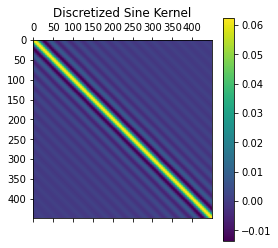

27


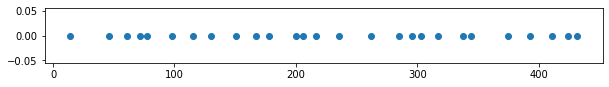

In [427]:
def sine_kernel(x,y):
    return math.sin(math.pi*(x-y))/(math.pi*(x-y))

interval_size = 30
k=4

kernel = np.array([[sine_kernel(m/(2**k),l/2**k) if m != l else 1 for m in range(interval_size*(2**k-1))] for l in range(interval_size*(2**k-1))])/(2**k)

# print(np.around(np.linalg.eig(kernel)[0].real,4))

plt.matshow(np.array(kernel))
plt.colorbar()
plt.title("Discretized Sine Kernel")
plt.show()

samples,_ = sampling_algorithm_1(kernel)
fig = plt.figure(figsize=(10,1))
plt.scatter(samples,np.zeros(len(samples)))
print(len(samples))

# Sanity Check With GUE Eigenvalues

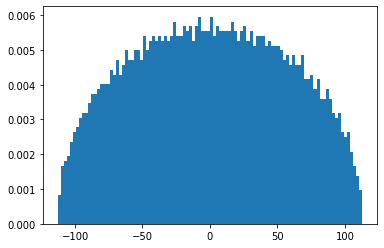

In [70]:
size=3200
A = np.random.randn(size,size)
GOE = (A + A.T) / np.sqrt(2)
eigenvalues = linalg.eigvals(GOE).real

plt.hist(eigenvalues, density=True, bins=100)
plt.show()